import and inline matplotlib

In [1]:
import ROOT as rt
#from root_numpy import root2array, tree2array, array2tree
#from root_pandas import read_root
import h5py 
import uproot

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

import json
#from prettytable import PrettyTable 

from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'

Welcome to JupyROOT 6.22/06
gpu-ibanks-2.hep.caltech.edu  Wed Oct 20 21:00:14 2021  470.57.02
[0] NVIDIA TITAN Xp  | 29'C,   0 % | 11521 / 12196 MB | 3019(11517M)
[1] NVIDIA TITAN Xp  | 28'C,   0 % |     1 / 12196 MB |
[2] NVIDIA TITAN Xp  | 30'C,   0 % |     1 / 12196 MB |
[3] NVIDIA TITAN Xp  | 24'C,   0 % |     1 / 12196 MB |
[4] NVIDIA TITAN Xp  | 26'C,   0 % |     1 / 12196 MB |
[5] NVIDIA TITAN Xp  | 24'C,   0 % |     1 / 12196 MB |


make a random variable

In [3]:
variables = ['fatJet2PNetXbb', 'fatJet1PNetXbb','genHH_pt','genHiggs1Pt','genHiggs2Pt','fatJet1Pt','fatJet2Pt','hh_pt']
id_variables = ['run','lumi','event']
wt_variables = ['Weight']
mass_variables = ['hh_mass']
#DNN=['disc_qcd_and_ttbar_Run2_enhanced_v24']
year='2018'

obsdict = {
  b'genHiggs1Pt': "gen ${pT_{H1}}$ [GeV]",
  b'genHiggs2Pt': "gen ${pT_{H2}}$ [GeV]",
  b'fatJet1Pt': "${pT_{H1}}$ [GeV]",
  b'fatJet2Pt': "${pT_{H2}}$ [GeV]",  
  b'hh_mass': "${m_{HH}}$ [GeV]"   
}


In [4]:
def samp_to_df(file_name, treename):
    samp_file = uproot.open(file_name)
    samp_array = samp_file[treename].arrays()
    samp_df = pd.DataFrame(samp_array)
    return samp_df

In [5]:
import ROOT as rt
import pandas as pd

path='/storage/af/user/nlu/work/HH/ntuples/20210417/option0/combined/'

file_kl1 =path+year+'/GluGluToHHTo4B_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8.root'
file_kl0 =path+year+'/GluGluToHHTo4B_node_cHHH0_TuneCP5_PSWeights_13TeV-powheg-pythia8.root'
file_kl5 =path+year+'/GluGluToHHTo4B_node_cHHH5_TuneCP5_PSWeights_13TeV-powheg-pythia8.root'
file_kl2p45 =path+year+'/GluGluToHHTo4B_node_cHHH2p45_TuneCP5_PSWeights_13TeV-powheg-pythia8.root'

l1_frame_all = samp_to_df(file_kl1,'tree')
l0_frame_all = samp_to_df(file_kl0,'tree')
l5_frame_all = samp_to_df(file_kl5,'tree')
l2p45_frame_all = samp_to_df(file_kl2p45,'tree')

In [6]:
l1_frame = l1_frame_all[(l1_frame_all[b'weight']<10.)]
l0_frame = l0_frame_all[(l0_frame_all[b'weight']<10.)]
l5_frame = l5_frame_all[(l5_frame_all[b'weight']<10.) & (l5_frame_all[b'weight']>-10.)]
l2p45_frame = l2p45_frame_all[(l2p45_frame_all[b'weight']<10.)]

In [12]:
#print(l1_frame.values)
print(l5_frame[b'weight'])
print(l5_frame.loc[(l5_frame[b'hh_mass'] > 0. ), b'weight'].sum())
type(l5_frame[b'weight'])

0         0.080204
1         0.080204
2         0.080204
3         0.080204
4         0.080204
            ...   
812195    0.080204
812196    0.080204
812197    0.080204
812198    0.080204
812199    0.080204
Name: b'weight', Length: 812200, dtype: float32
5796.325


pandas.core.series.Series

In [7]:
from sympy import Matrix
from sympy import *

class GGFHHSample:
    def __init__(self, val_kl, val_kt, val_xs, label):
        self.val_kl  = val_kl
        self.val_kt  = val_kt
        self.val_xs  = val_xs
        self.label   = label
        
def param_kl(var0, var1, var2, kl,kt):
    
    GGF_sample_list_comb3 = [
        GGFHHSample(1,1,   val_xs = 0.031047, label = 'ggHH_kl_1_kt_1'  ),
        #GGFHHSample(0,1,   val_xs = 0.069725, label = 'ggHH_kl_0_kt_1'  ),
        GGFHHSample(5,1,   val_xs = 0.091172, label = 'ggHH_kl_5_kt_1'  ),
        GGFHHSample(2.45,1,   val_xs = 0.013124, label = 'ggHH_kl_2p45_kt_1'  ),
    ]
    
    M_tofill = [
            [None,None,None],
            [None,None,None],
            [None,None,None],
        ]

     ### the vector of samples (i.e. cross sections)
    s_tofill = Matrix([
            [var0],
            [var1],
            [var2]
    ])
    
    for isample, sample in enumerate(GGF_sample_list_comb3):

            ## implement the 3 scalings - box, triangle, interf
            M_tofill[isample][0] = sample.val_kt**4
            M_tofill[isample][1] = sample.val_kt**2 * sample.val_kl**2
            M_tofill[isample][2] = sample.val_kt**3 * sample.val_kl

    kls, kts, box, tri, interf, s1, s2, s3 = symbols('kl kt box tri interf s1 s2 s3')

    ### the vector of couplings
    c = Matrix([
            [kt**4]         ,
            [kt**2 * kl**2] ,
            [kt**3 * kl]    ,
    ])
    
    cs = Matrix([
            [kts**4]         ,
            [kts**2 * kls**2] ,
            [kts**3 * kls]    ,
    ])
    
    ### the vector of components
    v = Matrix([
            [box]   ,
            [tri]   ,
            [interf],
    ])
    
    ### the vector of samples (i.e. cross sections)
    s = Matrix([
            [s1] ,
            [s2] ,
            [s3]
    ])
    
    ####    
    Minv   = Matrix(M_tofill).inv()
    coeffs = c.transpose() * Minv # coeffs * s is the sigma, accessing per component gives each sample scaling
    sigma  = cs.transpose() * Minv*s
    
    var_kl = coeffs*s_tofill
    
    #print(sigma)
    
    return var_kl

In [8]:
def three_terms(var0, var1, var2, iterm):
    #iterm 0,1,2: box, triangle, interference
    
    GGF_sample_list_comb3 = [
        GGFHHSample(1,1,   val_xs = 0.031047, label = 'ggHH_kl_1_kt_1'  ),
        #GGFHHSample(0,1,   val_xs = 0.069725, label = 'ggHH_kl_0_kt_1'  ),
        GGFHHSample(5,1,   val_xs = 0.091172, label = 'ggHH_kl_5_kt_1'  ),
        GGFHHSample(2.45,1,   val_xs = 0.013124, label = 'ggHH_kl_2p45_kt_1'  ),
    ]
    
    M_tofill = [
            [None,None,None],
            [None,None,None],
            [None,None,None],
        ]

     ### the vector of samples (i.e. cross sections)
    s_tofill = Matrix([
            [var0],
            [var1],
            [var2]
    ])
    
    for isample, sample in enumerate(GGF_sample_list_comb3):

            ## implement the 3 scalings - box, triangle, interf
            M_tofill[isample][0] = sample.val_kt**4
            M_tofill[isample][1] = sample.val_kt**2 * sample.val_kl**2
            M_tofill[isample][2] = sample.val_kt**3 * sample.val_kl

    kls, kts, box, tri, interf, s1, s2, s3 = symbols('kl kt box tri interf s1 s2 s3')

    ### the vector of couplings
    c = Matrix([
            [1]         ,
            [0] ,
            [0]    ,
    ])
    
    if iterm == 1:
        c = Matrix([
            [0]         ,
            [1] ,
            [0]    ,
    ])
    elif iterm == 2:
        c = Matrix([
            [0]         ,
            [0] ,
            [1]    ,
    ])
        
    ### the vector of components
    v = Matrix([
            [box]   ,
            [tri]   ,
            [interf],
    ])
    
    ### the vector of samples (i.e. cross sections)
    s = Matrix([
            [s1] ,
            [s2] ,
            [s3]
    ])
    
    ####    
    Minv   = Matrix(M_tofill).inv()
    coeffs = c.transpose() * Minv # coeffs * s is the sigma, accessing per component gives each sample scaling
    sigma  = v.transpose() * Minv*s
    
    var_kl = coeffs*s_tofill
    
    #print(sigma)
    
    return var_kl

In [9]:
nbins = 80
obs = b'hh_mass'


colors = cm.rainbow(np.linspace(0, 1, 10))

lumi= 137.


#SM, kl0, kl5, kl2.45
sumWs_2018 = [79368.688-53692.337,75088.125-15431.799, 48749.730+15331.955, 9951.8613]
xs = [31.05*5.824e-01*5.824e-01,69.7*5.824e-01*5.824e-01,91.7*5.824e-01*5.824e-01,13.15*5.824e-01*5.824e-01] #fb
#ggHHto4B_13TeV           31.05e-3*5.824e-01*5.824e-01
#ggHHto4B_13TeV_cHHH0     69.7e-3*5.824e-01*5.824e-01
#ggHHto4B_13TeV_cHHH5     91.7e-3*5.824e-01*5.824e-01
#ggHHto4B_13TeV_cHHH2p45  13.15e-3*5.824e-01*5.824e-01

In [10]:
def plot_MC_points(obs, minkl, nkl, nstep, hist_min, hist_max, nbins):

    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['red','blue','green','black']]
    labels= ["kl=1","kl=0","kl=5","kl=2.45"]
    plt.legend(handles, labels)
    print(obs)
    bins = np.linspace(hist_min, hist_max, nbins+1)
    hist_l0 = plt.hist(l0_frame[obs],weights=l0_frame[b'weight']*lumi*xs[1]/sumWs_2018[1],color='blue', bins=bins,density=False,histtype='step')
    hist_l1 = plt.hist(l1_frame[obs],weights=l1_frame[b'weight']*lumi*xs[0]/sumWs_2018[0],color='red', bins=bins,density=False,histtype='step')
    hist_l5 = plt.hist(l5_frame[obs],weights=l5_frame[b'weight']*lumi*xs[2]/sumWs_2018[2],color='green', bins=bins,density=False,histtype='step')
    hist_l2p45 = plt.hist(l2p45_frame[obs],weights=l2p45_frame[b'weight']*lumi*xs[3]/sumWs_2018[3],color='black', bins=bins,density=False,histtype='step')

    print("sum yield and acc x eff kl=0,",sum(hist_l0[0]), sum(hist_l0[0])/(lumi*xs[1]))
    print("sum yield and acc x eff kl=1",sum(hist_l1[0]), sum(hist_l1[0])/(lumi*xs[0]))
    print("sum yield and acc x eff kl=2.45",sum(hist_l2p45[0]), sum(hist_l2p45[0])/(lumi*xs[3]))
    print("sum yield and acc x eff kl=5",sum(hist_l5[0]), sum(hist_l5[0])/(lumi*xs[2]))
       
    plt.xlabel(obsdict[obs],fontsize=15)
    plt.ylabel("Events",fontsize=15)
    plt.title(obsdict[obs])
    #plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/genHiggs1Pt_kl_3MC.pdf", dpi=300)
    #plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/genHiggs1Pt_kl_3MC.eps", dpi=300)
    #plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/genHiggs1Pt_kl_3MC.png", dpi=300)
    plt.show()
    
    hist_x = np.ones_like(hist_l0[0])
    
    maxkl = minkl + nkl*nstep
    hist_kl = np.arange(minkl, maxkl, nstep)
    print("minkl, maxkl, nstep: ", minkl, maxkl, nstep)
    hist_acc = np.ones_like(hist_kl)
    
    colors = cm.rainbow(np.linspace(0, 1, nkl))

    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
    labels = ["kl="+str(x*nstep+minkl) for x in np.arange(nkl)]

    plt.legend(handles, labels, ncol=4,handleheight=2.4, labelspacing=0.05,bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    for ikl_index in range(nkl):
        ikl = ikl_index*nstep + minkl
        hist_temp = np.ones_like(hist_l0[0])
        for ibin in range(nbins):
            #print("ibin:",ibin)
            if ikl_index == 0:
                hist_x[ibin] = (hist_l0[1][ibin]+hist_l0[1][ibin+1])/2.
            hist_temp[ibin] = param_kl(hist_l1[0][ibin],hist_l5[0][ibin],hist_l2p45[0][ibin],ikl,1.)[0]/(param_kl(xs[0]*lumi,xs[2]*lumi,xs[3]*lumi,ikl,1.)[0])
        
        if ikl_index == 0:
            p_value = np.array([hist_temp])
        else:
            p_value = np.append(p_value,[hist_temp], axis=0)
            
        acc_tmp = sum(hist_temp)
        hist_kl[ikl_index] = ikl
        hist_acc[ikl_index] = acc_tmp
        print("acc x eff for kl=", ikl,acc_tmp)
  
        plt.plot(hist_x, p_value[ikl_index], color=colors[ikl_index])
    plt.title(obsdict[obs])
    plt.xlabel(obsdict[obs],fontsize=15)
    plt.ylabel("acceptance x efficiency",fontsize=15)
    plt.show()  
    
    for ikl_index in range(nkl):
        plt.plot(hist_x, p_value[ikl_index], color=colors[ikl_index])
    plt.yscale('log')
    plt.title(obsdict[obs])
    plt.xlabel(obsdict[obs],fontsize=15)
    plt.ylabel("acceptance x efficiency",fontsize=15)
    plt.show()
    
    
    print(hist_kl," acc ", hist_acc)
    plt.title("acceptance x efficiency vs kl")
    plt.plot(hist_kl, hist_acc)
    plt.xlabel("kl",fontsize=15)
    plt.ylabel("acceptance x efficiency",fontsize=15)
    plt.show() 
    
    #print(hist_kl," acc ", hist_acc)
    plt.title("acceptance x efficiency vs kl")
    plt.yscale('log')
    plt.plot(hist_kl, hist_acc)   
    plt.xlabel("kl",fontsize=15)
    plt.ylabel("acceptance x efficiency",fontsize=15)
    plt.show() 

b'hh_mass'
sum yield and acc x eff kl=0, 187.18440301005103 0.05779277933677522
sum yield and acc x eff kl=1 119.68040251956336 0.08294651367285386
sum yield and acc x eff kl=2.45 75.41006966422287 0.12340714053516048
sum yield and acc x eff kl=5 156.30475287627632 0.03668086332329938


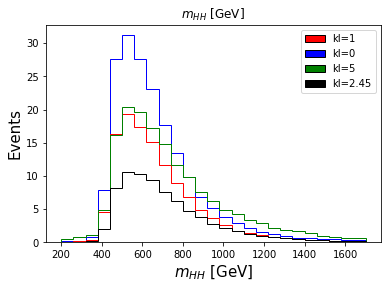

minkl, maxkl, nstep:  1.0 13.75 0.25
acc x eff for kl= 1.0 0.08294651367285388
acc x eff for kl= 1.25 0.09344829083477015
acc x eff for kl= 1.5 0.10569615945450538
acc x eff for kl= 1.75 0.11823365414761593
acc x eff for kl= 2.0 0.12762660765769482
acc x eff for kl= 2.25 0.12927221093442973
acc x eff for kl= 2.5 0.12105356087221539
acc x eff for kl= 2.75 0.10599279858619047
acc x eff for kl= 3.0 0.08942370610042209
acc x eff for kl= 3.25 0.0749215662600278
acc x eff for kl= 3.5 0.06357317119395979
acc x eff for kl= 3.75 0.05512354954429844
acc x eff for kl= 4.0 0.04893662244260297
acc x eff for kl= 4.25 0.04440649026916978
acc x eff for kl= 4.5 0.041062976600833356
acc x eff for kl= 4.75 0.038567126350255256
acc x eff for kl= 5.0 0.036680863323299374
acc x eff for kl= 5.25 0.03523779427275993
acc x eff for kl= 5.5 0.03412103518568627
acc x eff for kl= 5.75 0.033247667143727025
acc x eff for kl= 6.0 0.03255815727072004
acc x eff for kl= 6.25 0.032009215937728555
acc x eff for kl= 6.5 0.

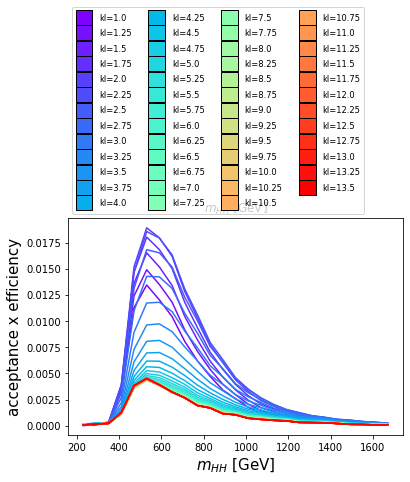

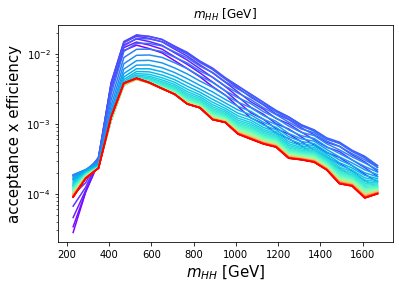

[ 1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75  6.    6.25  6.5   6.75
  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.    9.25  9.5   9.75
 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75 12.   12.25 12.5  12.75
 13.   13.25 13.5 ]  acc  [0.08294651 0.09344829 0.10569616 0.11823365 0.12762661 0.12927221
 0.12105356 0.1059928  0.08942371 0.07492157 0.06357317 0.05512355
 0.04893662 0.04440649 0.04106298 0.03856713 0.03668086 0.03523779
 0.03412104 0.03324767 0.03255816 0.03200922 0.03156896 0.03121363
 0.03092528 0.03069024 0.03049797 0.03034027 0.0302107  0.03010415
 0.03001658 0.02994469 0.02988585 0.02983791 0.0297991  0.02976797
 0.02974332 0.02972414 0.02970961 0.02969902 0.02969179 0.02968742
 0.02968548 0.02968563 0.02968754 0.02969097 0.02969568 0.02970149
 0.02970823 0.02971576 0.02972395]


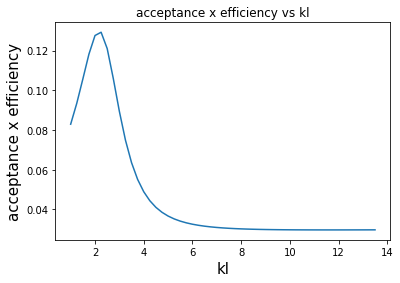

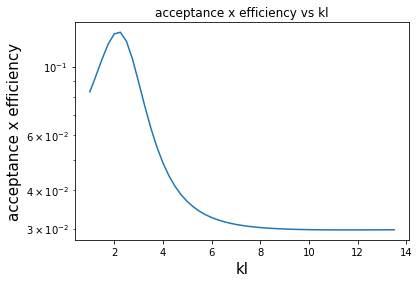

In [11]:
plot_MC_points(b'hh_mass',1.,51,0.25,200,1700,25)

b'fatJet1Pt'
sum yield and acc x eff kl=0, 102.81505424767056 0.03174392549316803
sum yield and acc x eff kl=1 68.62548146088034 0.04756204287807785
sum yield and acc x eff kl=2.45 46.78113828326752 0.07655644043592418
sum yield and acc x eff kl=5 88.48415532604577 0.020765044875899617


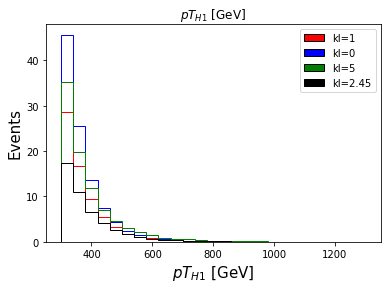

minkl, maxkl, nstep:  1.0 16.0 1.0
acc x eff for kl= 1.0 0.04756204287807786
acc x eff for kl= 2.0 0.07772329303975896
acc x eff for kl= 3.0 0.05565301169511368
acc x eff for kl= 4.0 0.029206331995090686
acc x eff for kl= 5.0 0.02076504487589961
acc x eff for kl= 6.0 0.01776235089082673
acc x eff for kl= 7.0 0.016487881076652052
acc x eff for kl= 8.0 0.015875917756630106
acc x eff for kl= 9.0 0.015557675922439998
acc x eff for kl= 10.0 0.015384103894291727
acc x eff for kl= 11.0 0.01528747212294324
acc x eff for kl= 12.0 0.01523414350201454
acc x eff for kl= 13.0 0.015206224572293014
acc x eff for kl= 14.0 0.01519366847129547
acc x eff for kl= 15.0 0.015190586159665845


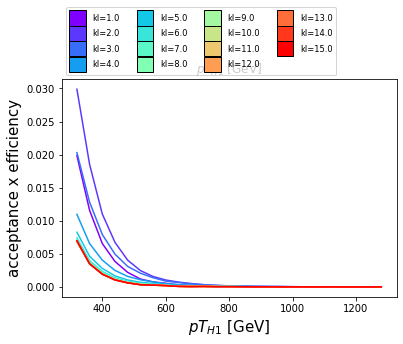

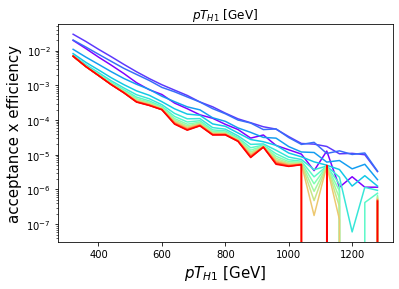

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]  acc  [0.04756204 0.07772329 0.05565301 0.02920633 0.02076504 0.01776235
 0.01648788 0.01587592 0.01555768 0.0153841  0.01528747 0.01523414
 0.01520622 0.01519367 0.01519059]


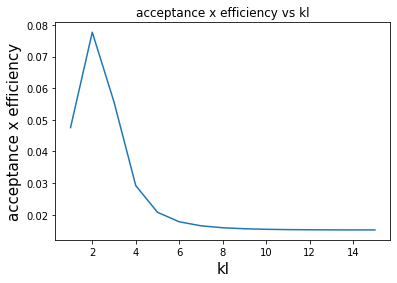

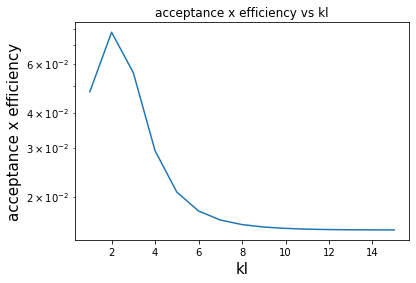

In [39]:
plot_MC_points(b'fatJet1Pt',1.,15,1.,300,1300,25)

b'fatJet2Pt'
sum yield and acc x eff kl=0, 63.22302741258909 0.019519972890382625
sum yield and acc x eff kl=1 43.29956285646858 0.03000948949779459
sum yield and acc x eff kl=2.45 33.48764092335966 0.05480188558399769
sum yield and acc x eff kl=5 71.05368443736188 0.016674544052583937


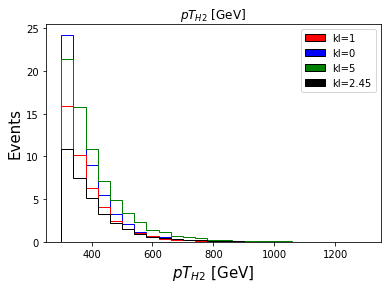

minkl, maxkl, nstep:  1.0 16.0 1.0
acc x eff for kl= 1.0 0.030009489497794598
acc x eff for kl= 2.0 0.053001937520737376
acc x eff for kl= 3.0 0.042124993620816134
acc x eff for kl= 4.0 0.02337827155595801
acc x eff for kl= 5.0 0.016674544052583937
acc x eff for kl= 6.0 0.014034194520563197
acc x eff for kl= 7.0 0.01278722577011226
acc x eff for kl= 8.0 0.012113449663872445
acc x eff for kl= 9.0 0.011712570967101684
acc x eff for kl= 10.0 0.011456533393980802
acc x eff for kl= 11.0 0.011283942522364
acc x eff for kl= 12.0 0.011162582769853773
acc x eff for kl= 13.0 0.011074305200356746
acc x eff for kl= 14.0 0.011008284575367526
acc x eff for kl= 15.0 0.010957754542074984


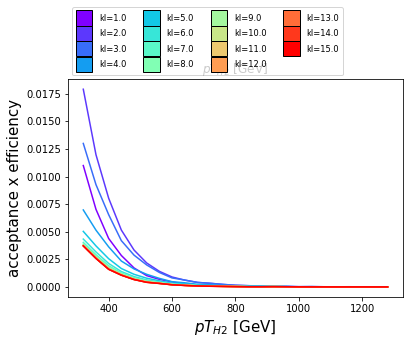

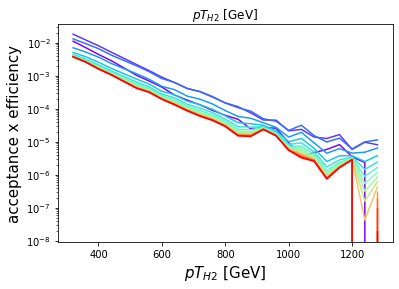

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]  acc  [0.03000949 0.05300194 0.04212499 0.02337827 0.01667454 0.01403419
 0.01278723 0.01211345 0.01171257 0.01145653 0.01128394 0.01116258
 0.01107431 0.01100828 0.01095775]


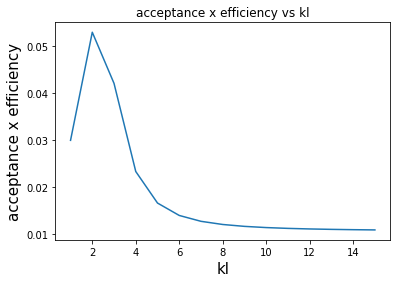

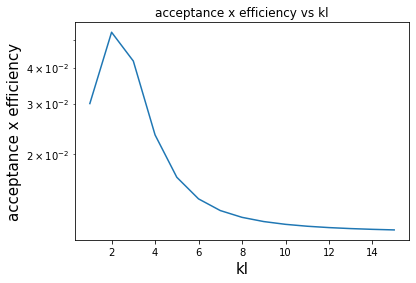

In [31]:
plot_MC_points(b'fatJet2Pt',1.,15,1.,300,1300,25)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 3237.9737642854575 0.9997173923062846
sum yield and acc x eff kl=1 1440.0094839660537 0.9980227659353403
sum yield and acc x eff kl=2.45 611.0632708817731 0.9999933865776376
sum yield and acc x eff kl=5 4263.322244196732 1.0004963871210455


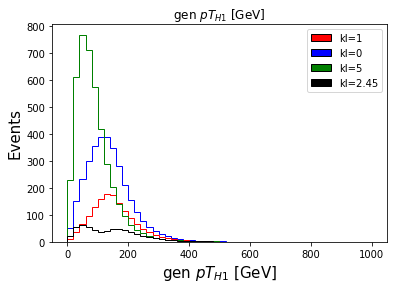

minkl, maxkl, nstep:  -5.0 20.0 0.5
acc x eff for kl= -5.0 0.9989993401244771
acc x eff for kl= -4.5 0.9989691431789302
acc x eff for kl= -4.0 0.9989345944547326
acc x eff for kl= -3.5 0.9988947270066345
acc x eff for kl= -3.0 0.9988482867683712
acc x eff for kl= -2.5 0.998793632958416
acc x eff for kl= -2.0 0.9987286098084622
acc x eff for kl= -1.5 0.9986504045560268
acc x eff for kl= -1.0 0.9985554750496992
acc x eff for kl= -0.5 0.9984398768937275
acc x eff for kl= 0.0 0.9983012081631913
acc x eff for kl= 0.5 0.9981466333084383
acc x eff for kl= 1.0 0.9980227659353403
acc x eff for kl= 1.5 0.9981089037031144
acc x eff for kl= 2.0 0.9988182377110928
acc x eff for kl= 2.5 1.0001176470045139
acc x eff for kl= 3.0 1.0009030008616056
acc x eff for kl= 3.5 1.0009927477265892
acc x eff for kl= 4.0 1.0008395382999848
acc x eff for kl= 4.5 1.0006564530437625
acc x eff for kl= 5.0 1.0004963871210453
acc x eff for kl= 5.5 1.000365514412369
acc x eff for kl= 6.0 1.000259655766166
acc x eff for 

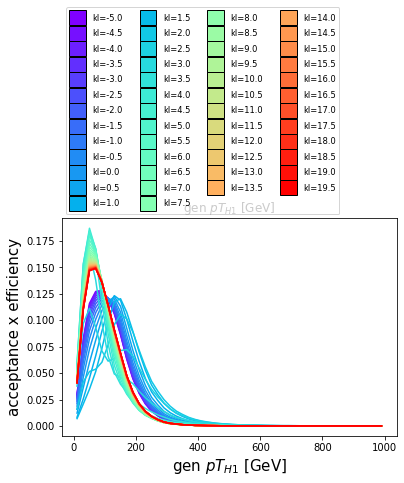

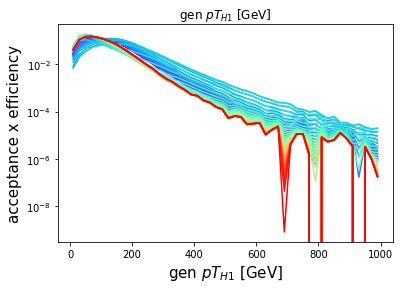

[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5]  acc  [0.99899934 0.99896914 0.99893459 0.99889473 0.99884829 0.99879363
 0.99872861 0.9986504  0.99855548 0.99843988 0.99830121 0.99814663
 0.99802277 0.9981089  0.99881824 1.00011765 1.000903   1.00099275
 1.00083954 1.00065645 1.00049639 1.00036551 1.00025966 1.00017349
 1.00010255 1.0000434  0.99999347 0.99995086 0.99991411 0.99988213
 0.99985406 0.99982924 0.99980715 0.99978737 0.99976956 0.99975344
 0.99973878 0.9997254  0.99971314 0.99970186 0.99969145 0.99968182
 0.99967288 0.99966456 0.9996568  0.99964954 0.99964274 0.99963636
 0.99963035 0.99962469]


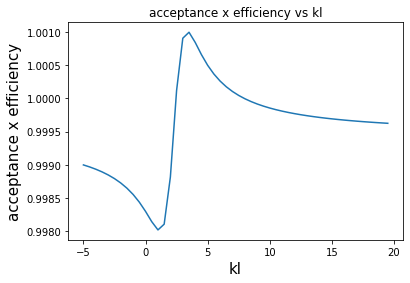

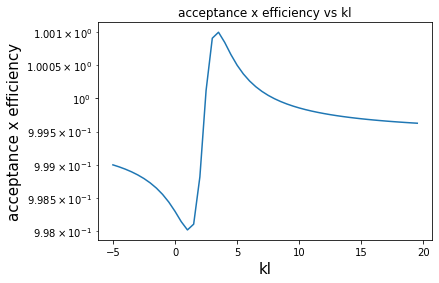

In [34]:
plot_MC_points(b'genHiggs1Pt',-5.,50,0.5,0,1000,50)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 3237.9737642854575 0.9997173923062846
sum yield and acc x eff kl=1 1440.0094839660537 0.9980227659353403
sum yield and acc x eff kl=2.45 611.0632708817731 0.9999933865776376
sum yield and acc x eff kl=5 4263.322244196732 1.0004963871210455


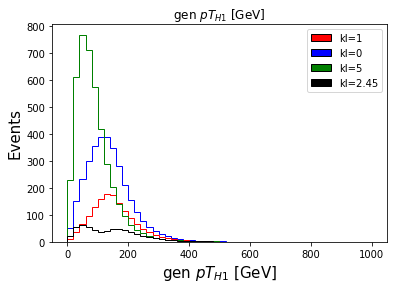

minkl, maxkl, nstep:  1.0 7.0 1
acc x eff for kl= 1.0 0.9980227659353403
acc x eff for kl= 2.0 0.9988182377110928
acc x eff for kl= 3.0 1.0009030008616056
acc x eff for kl= 4.0 1.0008395382999848
acc x eff for kl= 5.0 1.0004963871210453
acc x eff for kl= 6.0 1.000259655766166


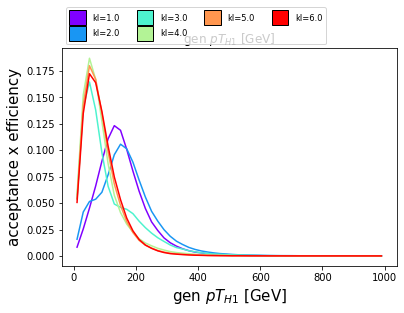

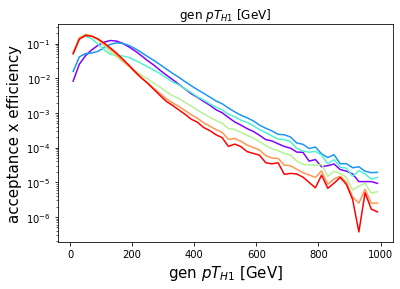

[1. 2. 3. 4. 5. 6.]  acc  [0.99802277 0.99881824 1.000903   1.00083954 1.00049639 1.00025966]


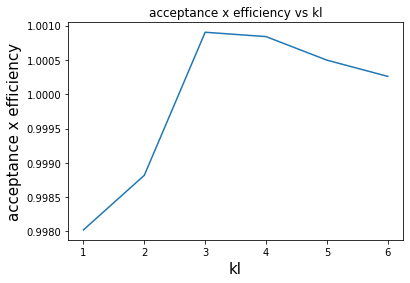

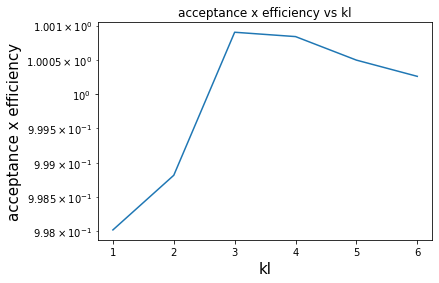

In [35]:
plot_MC_points(b'genHiggs1Pt',1.,6,1,0,1000,50)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 101.29518052727099 0.03127466777120869
sum yield and acc x eff kl=1 71.63020068191531 0.049644514015404824
sum yield and acc x eff kl=2.45 45.7542594784378 0.0748759728598503
sum yield and acc x eff kl=5 49.496104928407476 0.011615512813943114


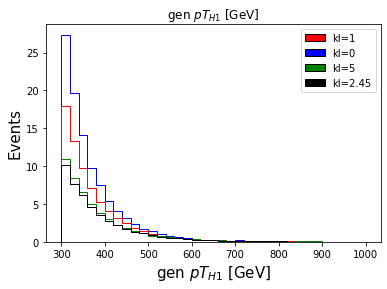

minkl, maxkl, nstep:  1.0 16.0 1.0
acc x eff for kl= 1.0 0.04964451401540483
acc x eff for kl= 2.0 0.08018782278039119
acc x eff for kl= 3.0 0.04870418925903695
acc x eff for kl= 4.0 0.019750950216546794
acc x eff for kl= 5.0 0.011615512813943116
acc x eff for kl= 6.0 0.00911434286067668
acc x eff for kl= 7.0 0.008246690006379027
acc x eff for kl= 8.0 0.007945273840407753
acc x eff for kl= 9.0 0.007866068092588477
acc x eff for kl= 10.0 0.007880295669316585
acc x eff for kl= 11.0 0.00793436216724367
acc x eff for kl= 12.0 0.008004299236738106
acc x eff for kl= 13.0 0.00807891039007767
acc x eff for kl= 14.0 0.008152884061771769
acc x eff for kl= 15.0 0.008223753468410226


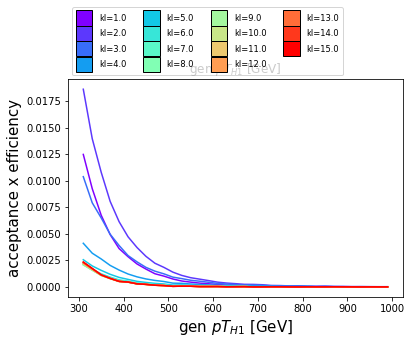

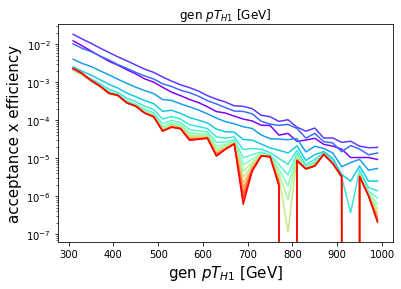

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]  acc  [0.04964451 0.08018782 0.04870419 0.01975095 0.01161551 0.00911434
 0.00824669 0.00794527 0.00786607 0.0078803  0.00793436 0.0080043
 0.00807891 0.00815288 0.00822375]


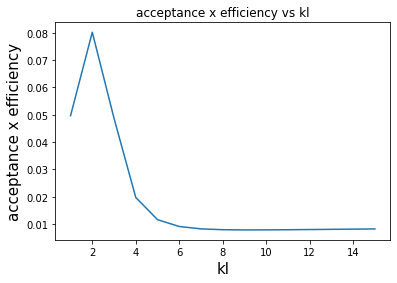

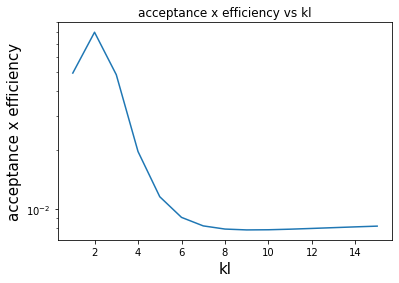

In [41]:
plot_MC_points(b'genHiggs1Pt',1.,15,1.,300,1000,35)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 3237.743645238587 0.9996463435485723
sum yield and acc x eff kl=1 1439.729265500982 0.9978285558202743
sum yield and acc x eff kl=2.45 610.8418821763997 0.999631088184352
sum yield and acc x eff kl=5 4262.959686166014 1.0004113037097813


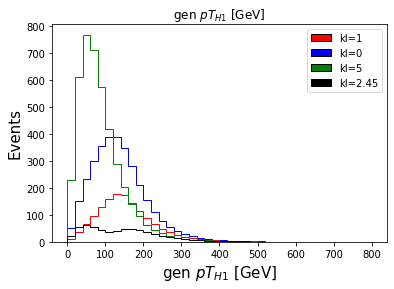

minkl, maxkl, nstep:  -5.0 15.0 0.1
acc x eff for kl= -5.0 0.9989408714154835
acc x eff for kl= -4.9 0.9989349002563426
acc x eff for kl= -4.8 0.9989287709929364
acc x eff for kl= -4.7 0.9989224774397096
acc x eff for kl= -4.6 0.9989160130952089
acc x eff for kl= -4.5 0.9989093711225507
acc x eff for kl= -4.4 0.9989025443285093
acc x eff for kl= -4.3 0.9988955251411257
acc x eff for kl= -4.2 0.9988883055857276
acc x eff for kl= -4.1 0.9988808772592391
acc x eff for kl= -4.0 0.9988732313026625
acc x eff for kl= -3.9 0.9988653583715926
acc x eff for kl= -3.8 0.9988572486046274
acc x eff for kl= -3.7 0.9988488915895315
acc x eff for kl= -3.5999999999999996 0.9988402763269945
acc x eff for kl= -3.5 0.9988313911918361
acc x eff for kl= -3.4 0.9988222238914874
acc x eff for kl= -3.3 0.9988127614216
acc x eff for kl= -3.2 0.9988029900186214
acc x eff for kl= -3.0999999999999996 0.998792895109186
acc x eff for kl= -3.0 0.9987824612561971
acc x eff for kl= -2.9 0.9987716721014778
acc x eff for 

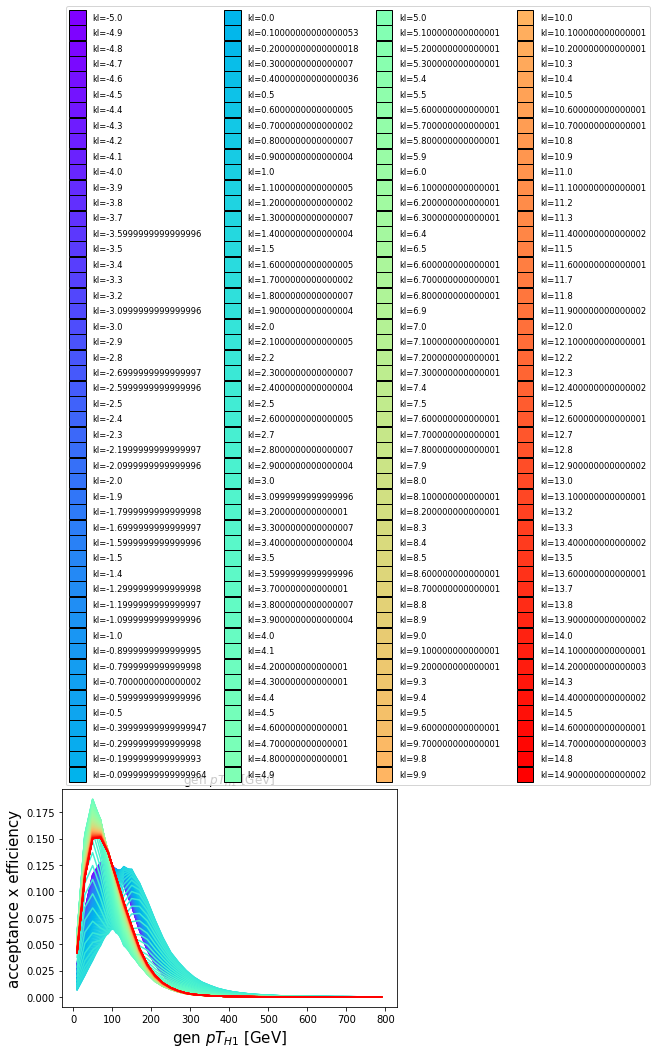

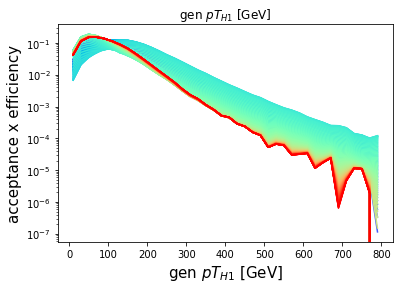

[-5.  -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7
 -3.6 -3.5 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3
 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9
 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3
  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7
  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1
  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5
  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9
  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3
 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7
 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1
 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5
 14.6 

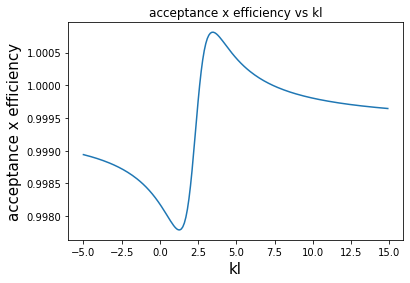

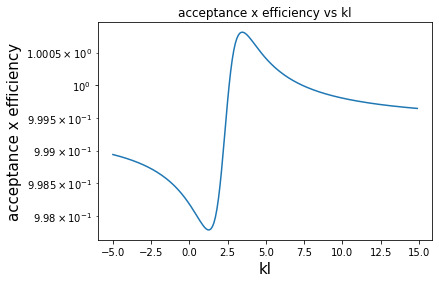

In [12]:
plot_MC_points(b'genHiggs1Pt',-5.,200,0.1,0,800,40)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 434.73556388738234 0.13422366452317583
sum yield and acc x eff kl=1 259.83231742383555 0.18008115293832241
sum yield and acc x eff kl=2.45 116.2427622112873 0.1902290629922256
sum yield and acc x eff kl=5 175.32278768325023 0.04114392617068795


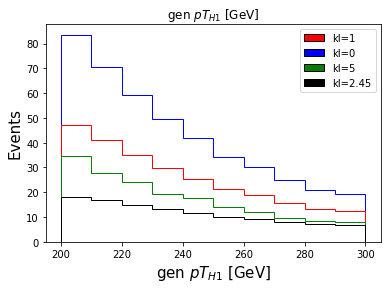

minkl, maxkl, nstep:  -5.0 15.0 0.1
acc x eff for kl= -5.0 0.08132688841471816
acc x eff for kl= -4.9 0.08164321758135602
acc x eff for kl= -4.8 0.08196917855519635
acc x eff for kl= -4.7 0.08230520491143142
acc x eff for kl= -4.6 0.0826517559370769
acc x eff for kl= -4.5 0.08300931851585512
acc x eff for kl= -4.4 0.08337840917698613
acc x eff for kl= -4.3 0.08375957632429332
acc x eff for kl= -4.2 0.08415340266387641
acc x eff for kl= -4.1 0.08456050785067426
acc x eff for kl= -4.0 0.0849815513765739
acc x eff for kl= -3.9 0.08541723572534245
acc x eff for kl= -3.8 0.08586830982261408
acc x eff for kl= -3.7 0.08633557281249335
acc x eff for kl= -3.5999999999999996 0.08681987819609148
acc x eff for kl= -3.5 0.08732213837155119
acc x eff for kl= -3.4 0.08784332961989953
acc x eff for kl= -3.3 0.0883844975864752
acc x eff for kl= -3.2 0.08894676331378264
acc x eff for kl= -3.0999999999999996 0.08953132988852655
acc x eff for kl= -3.0 0.09013948977337653
acc x eff for kl= -2.9 0.090772632

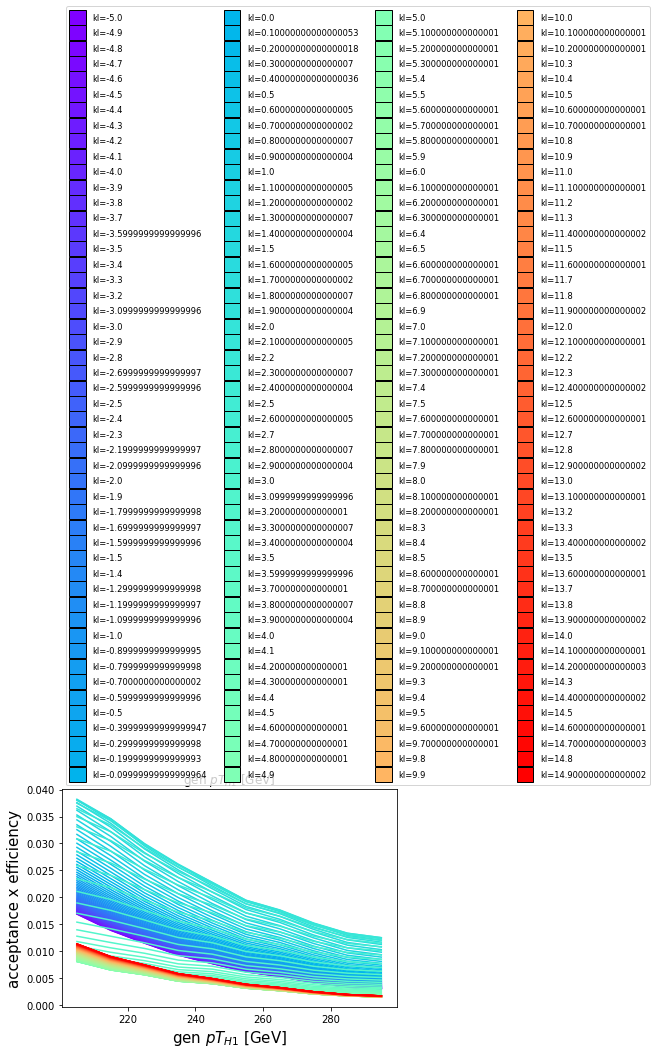

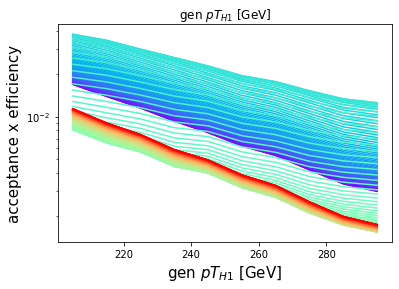

[-5.  -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7
 -3.6 -3.5 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3
 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9
 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3
  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7
  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1
  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5
  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9
  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3
 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7
 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1
 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5
 14.6 

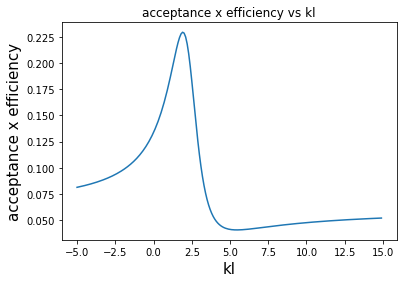

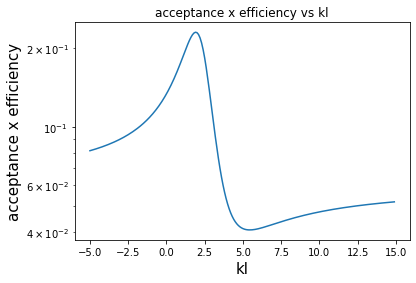

In [13]:
plot_MC_points(b'genHiggs1Pt',-5.,200,0.1,200,300,10)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 434.73556388738234 0.13422366452317583
sum yield and acc x eff kl=1 259.83231742383555 0.18008115293832241
sum yield and acc x eff kl=2.45 116.2427622112873 0.1902290629922256
sum yield and acc x eff kl=5 175.32278768325023 0.04114392617068795


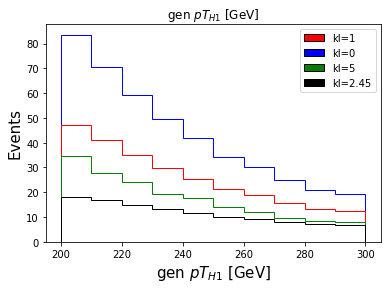

minkl, maxkl, nstep:  1.0 8.5 0.5
acc x eff for kl= 1.0 0.18008115293832244
acc x eff for kl= 1.5 0.21331386966681604
acc x eff for kl= 2.0 0.22847893096697944
acc x eff for kl= 2.5 0.18320361864658663
acc x eff for kl= 3.0 0.11261704377208541
acc x eff for kl= 3.5 0.06980035757788784
acc x eff for kl= 4.0 0.05105350895868223
acc x eff for kl= 4.5 0.04368048338105228
acc x eff for kl= 5.0 0.04114392617068795
acc x eff for kl= 5.5 0.0406688340537522
acc x eff for kl= 6.0 0.04107795302648112
acc x eff for kl= 6.5 0.04185309150357894
acc x eff for kl= 7.0 0.042758186190315337
acc x eff for kl= 7.5 0.04368378483436045
acc x eff for kl= 8.0 0.04457967471768126


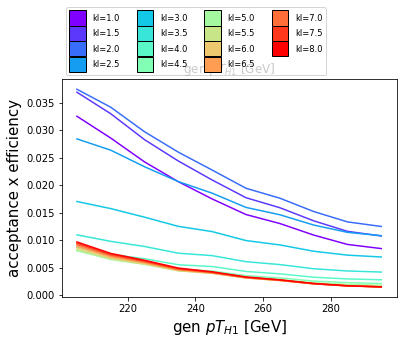

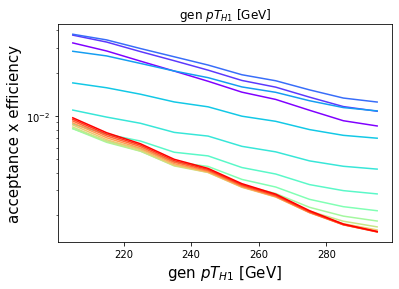

[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8. ]  acc  [0.18008115 0.21331387 0.22847893 0.18320362 0.11261704 0.06980036
 0.05105351 0.04368048 0.04114393 0.04066883 0.04107795 0.04185309
 0.04275819 0.04368378 0.04457967]


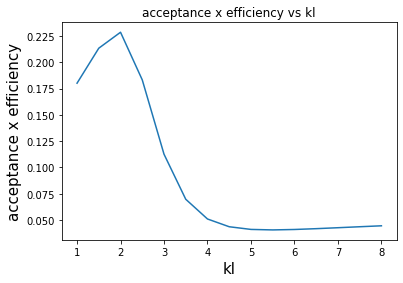

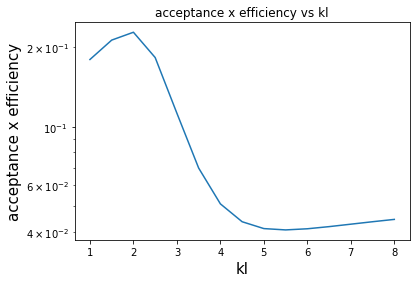

In [15]:
plot_MC_points(b'genHiggs1Pt',1.,15,0.5,200,300,10)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 101.29518052727099 0.03127466777120869
sum yield and acc x eff kl=1 71.63020068191531 0.049644514015404824
sum yield and acc x eff kl=2.45 45.7542594784378 0.0748759728598503
sum yield and acc x eff kl=5 49.496104928407476 0.011615512813943114


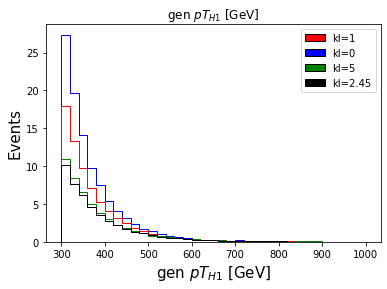

minkl, maxkl, nstep:  -5.0 15.0 0.1
acc x eff for kl= -5.0 0.014455925465794092
acc x eff for kl= -4.9 0.014541484934846258
acc x eff for kl= -4.8 0.01462991694364558
acc x eff for kl= -4.7 0.014721361303575736
acc x eff for kl= -4.6 0.014815966691294893
acc x eff for kl= -4.5 0.014913891339488405
acc x eff for kl= -4.4 0.015015303791319871
acc x eff for kl= -4.3 0.01512038372534875
acc x eff for kl= -4.2 0.015229322858494234
acc x eff for kl= -4.1 0.015342325935544897
acc x eff for kl= -4.0 0.015459611814756075
acc x eff for kl= -3.9 0.01558141466026214
acc x eff for kl= -3.8 0.01570798525337789
acc x eff for kl= -3.7 0.015839592436397112
acc x eff for kl= -3.5999999999999996 0.015976524704245723
acc x eff for kl= -3.5 0.016119091961342612
acc x eff for kl= -3.4 0.016267627463303014
acc x eff for kl= -3.3 0.016422489965729082
acc x eff for kl= -3.2 0.01658406610532238
acc x eff for kl= -3.0999999999999996 0.01675277304198089
acc x eff for kl= -3.0 0.016929061394478667
acc x eff for kl

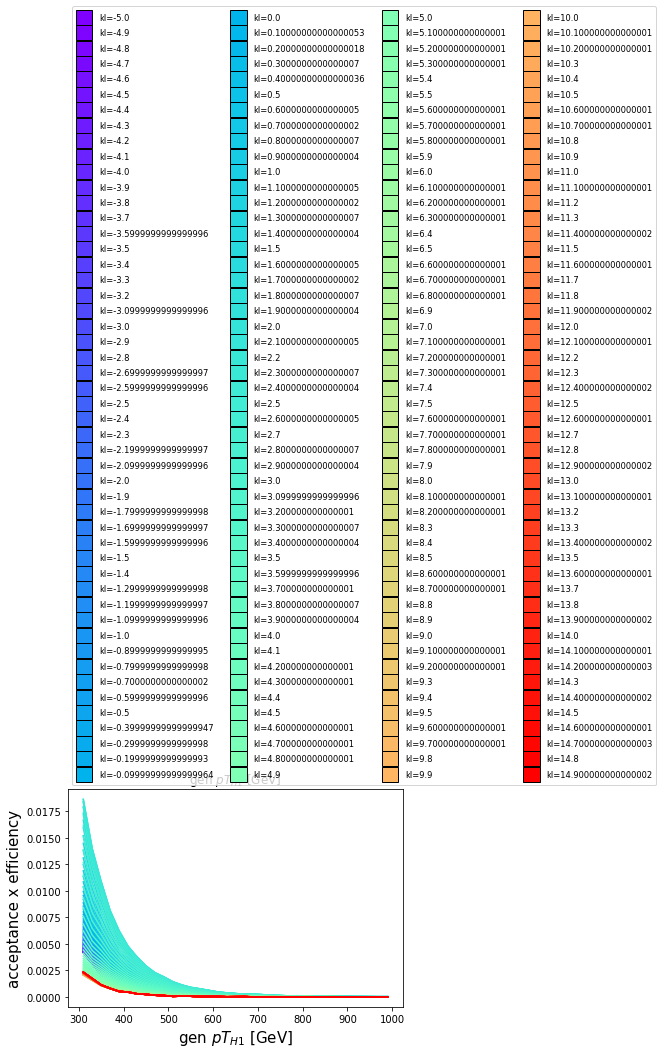

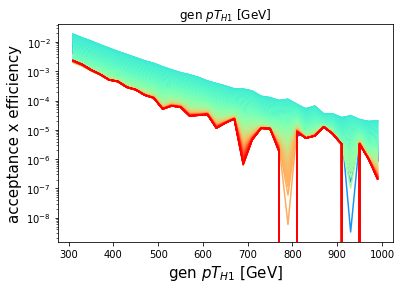

[-5.  -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7
 -3.6 -3.5 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3
 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9
 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3
  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7
  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1
  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5
  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9
  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3
 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7
 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1
 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5
 14.6 

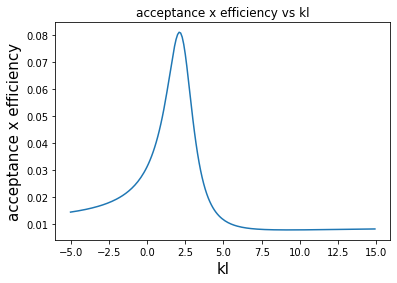

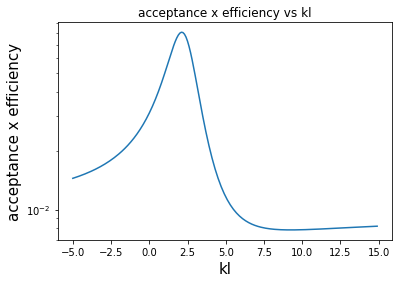

In [16]:
plot_MC_points(b'genHiggs1Pt',-5.,200,0.1,300,1000,35)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 2050.2271173749423 0.6330031855184027
sum yield and acc x eff kl=1 1030.4348419299254 0.7141601791584398
sum yield and acc x eff kl=2.45 329.0348440717291 0.538459245882238
sum yield and acc x eff kl=5 1320.9359325690862 0.30999102400779127


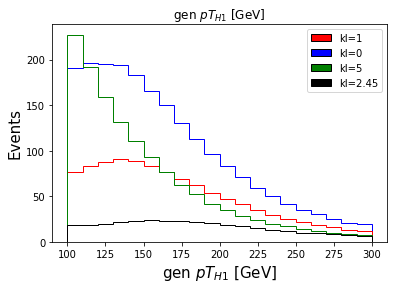

minkl, maxkl, nstep:  1.0 8.5 0.5
acc x eff for kl= 1.0 0.71416017915844
acc x eff for kl= 1.5 0.7461751647968926
acc x eff for kl= 2.0 0.6968677405323513
acc x eff for kl= 2.5 0.5181003858929392
acc x eff for kl= 3.0 0.357728826022135
acc x eff for kl= 3.5 0.29733293040674025
acc x eff for kl= 4.0 0.2892530225890222
acc x eff for kl= 4.5 0.2977924288925032
acc x eff for kl= 5.0 0.3099910240077913
acc x eff for kl= 5.5 0.3219003921190573
acc x eff for kl= 6.0 0.332493998771902
acc x eff for kl= 6.5 0.3416519439972655
acc x eff for kl= 7.0 0.34951525950075674
acc x eff for kl= 7.5 0.35627850556190543
acc x eff for kl= 8.0 0.3621255743015885


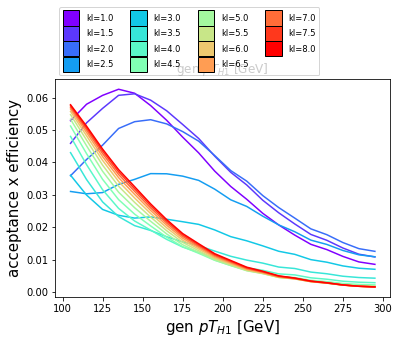

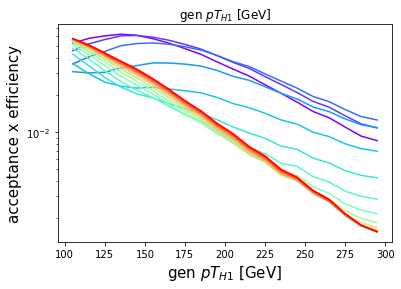

[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8. ]  acc  [0.71416018 0.74617516 0.69686774 0.51810039 0.35772883 0.29733293
 0.28925302 0.29779243 0.30999102 0.32190039 0.332494   0.34165194
 0.34951526 0.35627851 0.36212557]


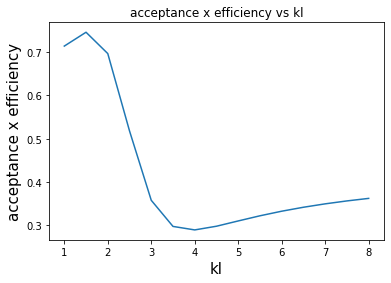

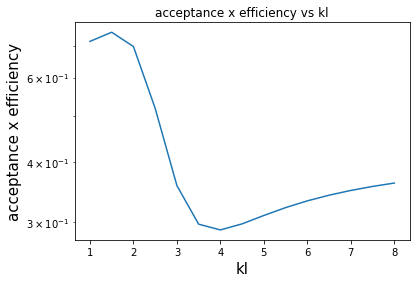

In [45]:
plot_MC_points(b'genHiggs1Pt',1.,15,0.5,100,300,20)

b'genHiggs1Pt'
sum yield and acc x eff kl=0, 2830.379231002138 0.8738734622452212
sum yield and acc x eff kl=1 1291.7741604593555 0.8952857845315688
sum yield and acc x eff kl=2.45 456.5821889605292 0.7471880427878118
sum yield and acc x eff kl=5 2994.47740064467 0.7027298545726262


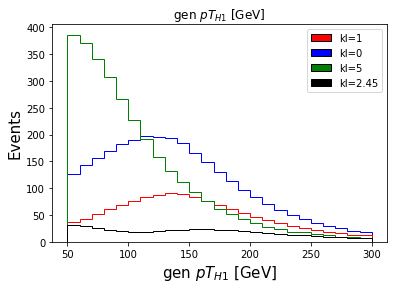

minkl, maxkl, nstep:  -5.0 15.0 0.1
acc x eff for kl= -5.0 0.8173389361798815
acc x eff for kl= -4.9 0.8177847393409303
acc x eff for kl= -4.8 0.818242185698088
acc x eff for kl= -4.7 0.8187117235076948
acc x eff for kl= -4.6 0.8191938234616751
acc x eff for kl= -4.5 0.819688980037179
acc x eff for kl= -4.4 0.8201977129373623
acc x eff for kl= -4.3 0.8207205686295962
acc x eff for kl= -4.2 0.821258121987745
acc x eff for kl= -4.1 0.821810978045466
acc x eff for kl= -4.0 0.822379773867808
acc x eff for kl= -3.9 0.8229651805486278
acc x eff for kl= -3.8 0.8235679053415702
acc x eff for kl= -3.7 0.8241886939324531
acc x eff for kl= -3.5999999999999996 0.8248283328609151
acc x eff for kl= -3.5 0.8254876520990084
acc x eff for kl= -3.4 0.8261675277940341
acc x eff for kl= -3.3 0.8268688851822493
acc x eff for kl= -3.2 0.8275927016790218
acc x eff for kl= -3.0999999999999996 0.8283400101494375
acc x eff for kl= -3.0 0.8291119023611861
acc x eff for kl= -2.9 0.8299095326184887
acc x eff for k

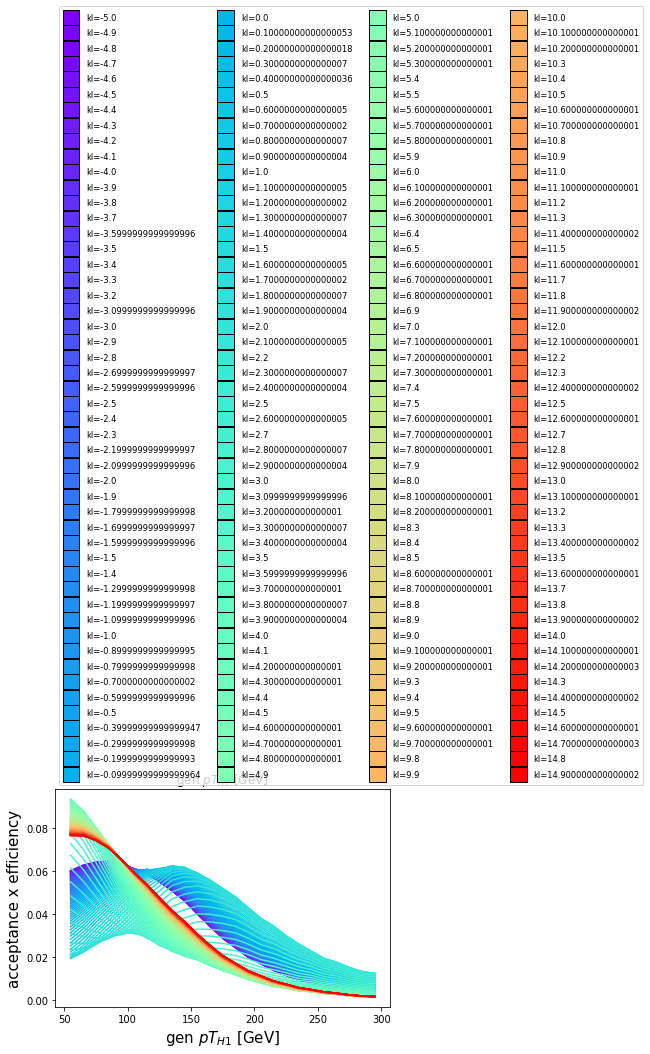

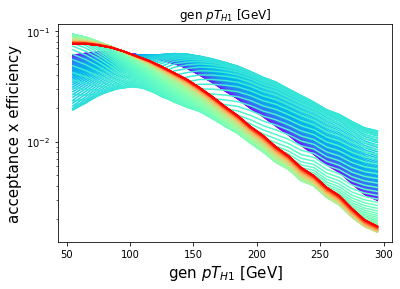

[-5.  -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7
 -3.6 -3.5 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3
 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9
 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3
  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7
  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1
  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5
  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9
  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3
 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7
 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1
 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5
 14.6 

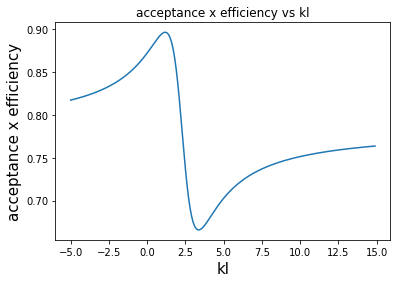

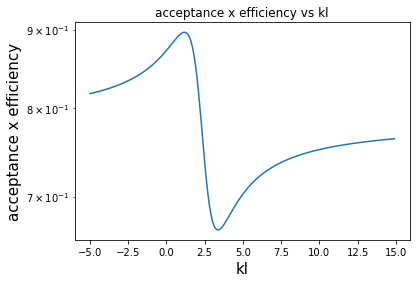

In [17]:
plot_MC_points(b'genHiggs1Pt',-5.,200,0.1,50,300,25)

b'genHiggs2Pt'
sum yield and acc x eff kl=0, 3237.9980726781746 0.9997248974699293
sum yield and acc x eff kl=1 1440.0027881241385 0.9980181252696065
sum yield and acc x eff kl=2.45 611.0608631707726 0.9999894464045131
sum yield and acc x eff kl=5 4263.290297703427 1.0004888900684414


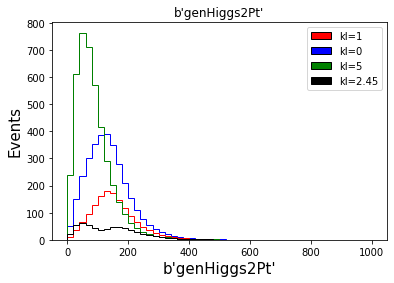

acc x eff for kl= 1 0.9980181252696068
acc x eff for kl= 2 0.9988149709292514
acc x eff for kl= 3 1.0008973571185833
acc x eff for kl= 4 1.0008323637716572
acc x eff for kl= 5 1.000488890068442
acc x eff for kl= 6 1.000252102963319
acc x eff for kl= 7 1.000095001237189
acc x eff for kl= 8 0.9999859456426929
acc x eff for kl= 9 0.9999066045671928
acc x eff for kl= 10 0.9998465725063531
acc x eff for kl= 11 0.999799684709971
acc x eff for kl= 12 0.9997621065672613
acc x eff for kl= 13 0.9997313448483631
acc x eff for kl= 14 0.9997057150994987
acc x eff for kl= 15 0.9996840412635001


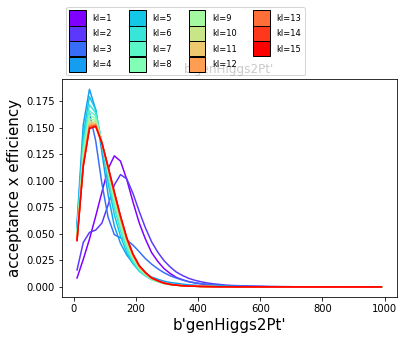

In [56]:
plot_MC_points(b'genHiggs2Pt',1,15,1,0,1000,50)

b'genHiggs2Pt'
sum yield and acc x eff kl=0, 101.95591022472036 0.031478666635387
sum yield and acc x eff kl=1 71.51567275296838 0.049565138510106306
sum yield and acc x eff kl=2.45 45.996215257781046 0.07527192887736439
sum yield and acc x eff kl=5 50.23701550595251 0.011789386219131429


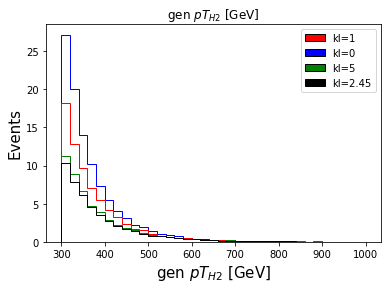

minkl, maxkl, nstep:  1.0 16.0 1.0
acc x eff for kl= 1.0 0.04956513851010633
acc x eff for kl= 2.0 0.08040062587024809
acc x eff for kl= 3.0 0.049133224275904816
acc x eff for kl= 4.0 0.02002603034598564
acc x eff for kl= 5.0 0.011789386219131427
acc x eff for kl= 6.0 0.00923372527316048
acc x eff for kl= 7.0 0.008333812749166933
acc x eff for kl= 8.0 0.008011482389939952
acc x eff for kl= 9.0 0.007917749808340249
acc x eff for kl= 10.0 0.007921350565372456
acc x eff for kl= 11.0 0.007967328250770084
acc x eff for kl= 12.0 0.008030913385252244
acc x eff for kl= 13.0 0.008100410168821655
acc x eff for kl= 14.0 0.008170180773465189
acc x eff for kl= 15.0 0.008237536730515348


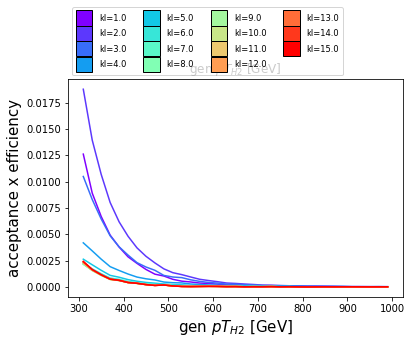

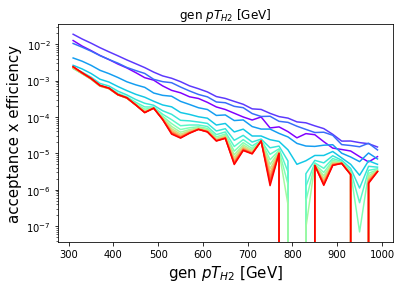

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]  acc  [0.04956514 0.08040063 0.04913322 0.02002603 0.01178939 0.00923373
 0.00833381 0.00801148 0.00791775 0.00792135 0.00796733 0.00803091
 0.00810041 0.00817018 0.00823754]


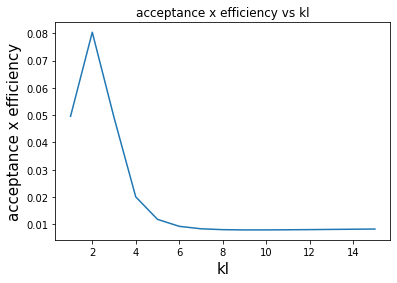

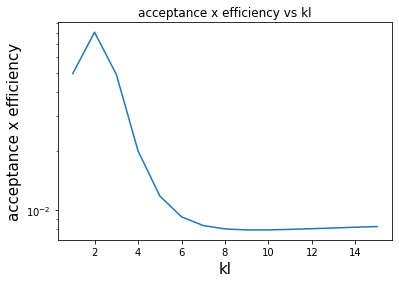

In [37]:
plot_MC_points(b'genHiggs2Pt',1.,15,1.,300,1000,35)

In [30]:
xs = [31.05*5.824e-01*5.824e-01,69.7*5.824e-01*5.824e-01,13.15*5.824e-01*5.824e-01,91.7*5.824e-01*5.824e-01] #fb
#ggHHto4B_13TeV           31.05e-3*5.824e-01*5.824e-01
#ggHHto4B_13TeV_cHHH0     69.7e-3*5.824e-01*5.824e-01
#ggHHto4B_13TeV_cHHH2p45  13.15e-3*5.824e-01*5.824e-01
#ggHHto4B_13TeV_cHHH5     91.7e-3*5.824e-01*5.824e-01


print("efficiency cat1")
print(1.875894/xs[0]) #SRv8p2Bin1__fatJet1MassRegressed->Integral()
print(2.266568/xs[1])
print(1.351649/xs[2])
print(0.944170/xs[3])


print("efficiency cat2")
print(1.973045/xs[0]) #SRv8p2Bin1__fatJet1MassRegressed->Integral()
print(2.418045/xs[1])
print(1.370346/xs[2])
print(1.035532/xs[3])


print("efficiency cat3")
print(2.125099/xs[0]) #SRv8p2Bin1__fatJet1MassRegressed->Integral()
print(2.632500/xs[1])
print(1.505970/xs[2])
print(1.131255/xs[3])


print("efficiency fail")
print(4.067225/xs[0]) #SRv8p2Bin1__fatJet1MassRegressed->Integral()
print(5.246571/xs[1])
print(2.862893/xs[2])
print(3.212155/xs[3])

efficiency cat1
0.17811641984853285
0.09587232118276663
0.30303684933683916
0.030355551586701668
efficiency cat2
0.1873409220350662
0.10227956402560302
0.3072286772241463
0.03329288692256728
efficiency cat3
0.20177847239966507
0.1113506788738009
0.3376352914076063
0.03637043065360496
efficiency fail
0.3861836306947242
0.22192183954780495
0.6418545603988102
0.10327243696260388


In [49]:
print("yield")

print("yield cat1")
print(1.875894) #SRv8p2Bin1__fatJet1MassRegressed->Integral()
print(2.266568)
print(1.351649)
print(0.944170)


print("yield cat2")
print(1.973045) #SRv8p2Bin1__fatJet1MassRegressed->Integral()
print(2.418045)
print(1.370346)
print(1.035532)


print("yield cat3")
print(2.125099) #SRv8p2Bin1__fatJet1MassRegressed->Integral()
print(2.632500)
print(1.505970)
print(1.131255)


print("yield fail")
print(4.067225) #SRv8p2Bin1__fatJet1MassRegressed->Integral()
print(5.246571)
print(2.862893)
print(3.212155)

yield
yield cat1
1.875894
2.266568
1.351649
0.94417
yield cat2
1.973045
2.418045
1.370346
1.035532
yield cat3
2.125099
2.6325
1.50597
1.131255
yield fail
4.067225
5.246571
2.862893
3.212155


In [50]:
#plot acceptance vs kl [i][j] [category][kl SM,0,2.45,5]
event_yield=np.array([[1.875894,2.266568,1.351649,0.94417],
                      [1.973045,2.418045,1.370346,1.035532],
                  [2.125099,2.6325,1.50597,1.131255],
                      [4.067225,5.246571,2.862893,3.212155]])

In [51]:
print(event_yield[0][0],event_yield[0][3],event_yield[0][2])

1.875894 0.94417 1.351649


In [52]:
nkl = 400
interval=0.2
minkl = -35
lumi=136.
#x-axis
v_kl = np.arange(nkl,dtype=float)
#y-axis
v_acc_BDT1 = np.arange(nkl,dtype=float)
v_yield_BDT1 = np.arange(nkl,dtype=float)

v_acc_BDT2 = np.arange(nkl,dtype=float)
v_yield_BDT2 = np.arange(nkl,dtype=float)

v_acc_BDT3 = np.arange(nkl,dtype=float)
v_yield_BDT3 = np.arange(nkl,dtype=float)

v_acc_BDT4 = np.arange(nkl,dtype=float)
v_yield_BDT4 = np.arange(nkl,dtype=float)

#print(v_kl,v_acc)
for ikl_index in range(nkl):
    
    ikl = ikl_index*interval + minkl
    
    v_kl[ikl_index] = ikl
    
    v_acc_BDT1[ikl_index] = (param_kl(event_yield[0][0],event_yield[0][3],event_yield[0][2],ikl,1.)[0])/(param_kl(xs[0]*lumi,xs[3]*lumi,xs[2]*lumi,ikl,1.)[0])
    v_yield_BDT1[ikl_index] = (param_kl(event_yield[0][0],event_yield[0][3],event_yield[0][2],ikl,1.)[0])
    
    v_acc_BDT2[ikl_index] = (param_kl(event_yield[1][0],event_yield[1][3],event_yield[1][2],ikl,1.)[0])/(param_kl(xs[0]*lumi,xs[3]*lumi,xs[2]*lumi,ikl,1.)[0])
    v_yield_BDT2[ikl_index] = (param_kl(event_yield[1][0],event_yield[1][3],event_yield[1][2],ikl,1.)[0])
    
    v_acc_BDT3[ikl_index] = (param_kl(event_yield[2][0],event_yield[2][3],event_yield[2][2],ikl,1.)[0])/(param_kl(xs[0]*lumi,xs[3]*lumi,xs[2]*lumi,ikl,1.)[0])
    v_yield_BDT3[ikl_index] = (param_kl(event_yield[2][0],event_yield[2][3],event_yield[2][2],ikl,1.)[0])
    
    v_acc_BDT4[ikl_index] = (param_kl(event_yield[3][0],event_yield[3][3],event_yield[3][2],ikl,1.)[0])/(param_kl(xs[0]*lumi,xs[3]*lumi,xs[2]*lumi,ikl,1.)[0])
    v_yield_BDT4[ikl_index] = (param_kl(event_yield[3][0],event_yield[3][3],event_yield[3][2],ikl,1.)[0])

v_acc = v_acc_BDT1 + v_acc_BDT2 +v_acc_BDT3+v_acc_BDT4  
v_yield = v_yield_BDT1 + v_yield_BDT2 + v_yield_BDT3 + v_yield_BDT4

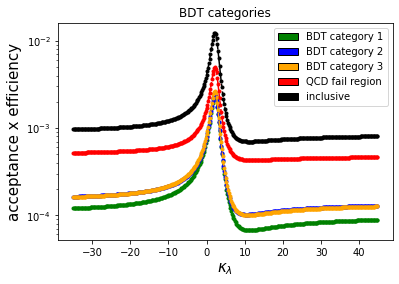

In [54]:
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['green','blue','orange','red','black']]
labels= ["BDT category 1","BDT category 2","BDT category 3","QCD fail category","inclusive"]
plt.legend(handles, labels)

plt.plot(v_kl, v_acc_BDT1, '.--', color="green")
plt.plot(v_kl, v_acc_BDT2, '.--', color="blue")
plt.plot(v_kl, v_acc_BDT3, '.--', color="orange")
plt.plot(v_kl, v_acc_BDT4, '.--', color="red")
plt.plot(v_kl, v_acc, '.--', color="black")

plt.xlabel("$\kappa_{\lambda}$",fontsize=15)
plt.ylabel("acceptance x efficiency",fontsize=15)
plt.title('BDT categories')
plt.yscale('log')
#plt.step(v_kl, v_acc, where='mid', color="green")

#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/acc_BDT_categories.pdf", dpi=300)
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/acc_BDT_categories.eps", dpi=300)
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/acc_BDT_categories.png", dpi=300)
plt.show()

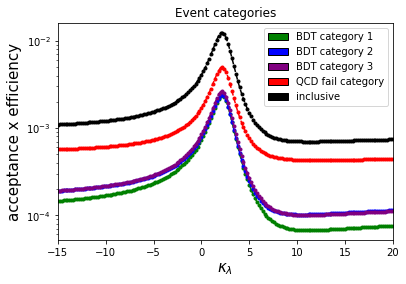

In [57]:
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['green','blue','purple','red','black']]
labels= ["BDT category 1","BDT category 2","BDT category 3","QCD fail category","inclusive"]
plt.legend(handles, labels)

plt.plot(v_kl, v_acc_BDT1, '.--', color="green")
plt.plot(v_kl, v_acc_BDT2, '.--', color="blue")
plt.plot(v_kl, v_acc_BDT3, '.--', color="purple")
plt.plot(v_kl, v_acc_BDT4, '.--', color="red")
plt.plot(v_kl, v_acc, '.--', color="black")

plt.xlim(-15, 20)
#plt.ylim(0, 0.03)
plt.xlabel("$\kappa_{\lambda}$",fontsize=15)
plt.ylabel("acceptance x efficiency",fontsize=15)
plt.title('Event categories')
plt.yscale('log')
#plt.step(v_kl, v_acc, where='mid', color="green")
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/acc_BDT_categories_zoom.pdf", dpi=300)
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/acc_BDT_categories_zoom.eps", dpi=300)
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/acc_BDT_categories_zoom.png", dpi=300)
plt.show()

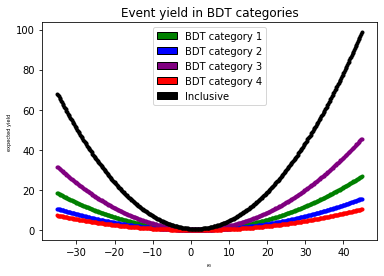

In [35]:
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['green','blue','purple','red','black']]
labels= ["BDT category 1","BDT category 2","BDT category 3","BDT category 4","Inclusive"]
plt.legend(handles, labels)

plt.plot(v_kl, v_yield_BDT1, '.--', color="green")
plt.plot(v_kl, v_yield_BDT2, '.--', color="blue")
plt.plot(v_kl, v_yield_BDT3, '.--', color="purple")
plt.plot(v_kl, v_yield_BDT4, '.--', color="red")
plt.plot(v_kl, v_yield, '.--', color="black")

plt.xlabel("$\kappa_{\lambda}$",fontsize=5)
plt.ylabel("expected yield",fontsize=5)
plt.title('Event yield in BDT categories')
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/yield_BDT_categories.pdf", dpi=300)
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/yield_BDT_categories.eps", dpi=300)
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/yield_BDT_categories.png", dpi=300)
plt.show()

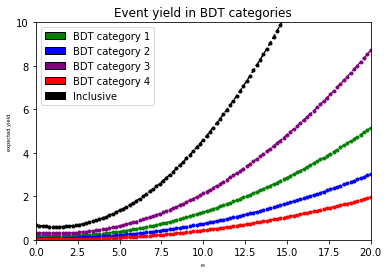

In [36]:
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['green','blue','purple','red','black']]
labels= ["BDT category 1","BDT category 2","BDT category 3","BDT category 4","Inclusive"]
plt.legend(handles, labels)

plt.plot(v_kl, v_yield_BDT1, '.--', color="green")
plt.plot(v_kl, v_yield_BDT2, '.--', color="blue")
plt.plot(v_kl, v_yield_BDT3, '.--', color="purple")
plt.plot(v_kl, v_yield_BDT4, '.--', color="red")
plt.plot(v_kl, v_yield, '.--', color="black")

plt.xlim(0, 20)
plt.ylim(0, 10)
plt.xlabel("$\kappa_{\lambda}$",fontsize=5)
plt.ylabel("expected yield",fontsize=5)
plt.title('Event yield in BDT categories')
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/yield_BDT_categories_zoom.pdf", dpi=300)
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/yield_BDT_categories_zoom.eps", dpi=300)
#plt.savefig("/storage/user/nlu/gpu/nlu/HH/output_plots/yield_BDT_categories_zoom.png", dpi=300)
plt.show()

print("1")

change the color

add a label

where is the label ?

add a legend

add another variable

change to the same binning

make it transparent

mass_cuts('BDT_incl',vbf_frame, bkg_frame,vbf_aux_frame,bkg_aux_frame)

A scatter plot with a circle drawn on top

http://matplotlib.org/
http://matplotlib.org/examples/index.html